In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from deepy.dataset import mnist

In [73]:
(X_train, y_train), (X_test, y_test) = mnist.load_mnist(
    flatten=False, normalize=False)

In [74]:
X_train.shape

(60000, 1, 28, 28)

In [75]:
x = X_train[0]

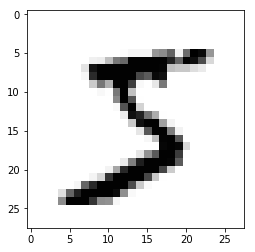

In [76]:
plt.imshow(x.reshape(28, 28), 'Greys')

In [77]:
y_train[0]

5

In [78]:
from matplotlib.image import imsave

In [79]:
imsave('mnist sample.png', x.reshape(28, 28))

In [80]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [81]:
class Layer:
    def __init__(self, 입력수, 출력수, 활성화):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.random.randn(출력수)
        self.activation = 활성화
        
    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        return self.activation(z)

In [82]:
layer1 = Layer(입력수=784, 출력수=50, 활성화=sigmoid)

In [83]:
layer1.W.shape

(784, 50)

In [84]:
layer1.b.shape

(50,)

In [85]:
class FeedForwardNet:
    def __init__(self):
        self.layers = []
        
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, X):
        """신경망 순전파"""
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward(layer_output)            
        y = layer_output
        return y

In [86]:
model = FeedForwardNet()

In [87]:
model.add(Layer(784, 50, sigmoid))
model.add(Layer(50, 100, sigmoid))
model.add(Layer(100, 10, lambda x: x))

기 훈련된 가중치 적재

In [88]:
import pickle

In [89]:
with open('data/mnist_weight.pkl', 'rb') as 파일:
    params = pickle.load(파일)

In [90]:
params.keys()

dict_keys(['b2', 'W1', 'b1', 'W2', 'W3', 'b3'])

In [91]:
model.layers[0].W = params['W1']
model.layers[0].b = params['b1']
model.layers[1].W = params['W2']
model.layers[1].b = params['b2']
model.layers[2].W = params['W3']
model.layers[2].b = params['b3']

In [92]:
X_test = X_test.reshape(-1, 1*28*28)

데이터 전처리 (크기 조정; scaling)

In [93]:
X_test = X_test.astype('float32') / 255.0

In [94]:
X_test.max(), X_test.min()

(1.0, 0.0)

In [95]:
Y_pred = model.predict(X_test)

In [96]:
Y_pred.shape

(10000, 10)

In [97]:
y_pred = np.argmax(Y_pred, axis=1)

In [98]:
y_pred[:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [99]:
y_test[:5]

array([7, 2, 1, 0, 4], dtype=uint8)

In [100]:
np.mean(y_pred == y_test)

0.93520000000000003

# 손실함수

In [101]:
def mean_squared_error(y_pred, y):
    return 0.5 * np.sum((y_pred - y)**2)

In [102]:
y = np.array([0, 1, 0])

In [104]:
np.argmax(y)

1

In [103]:
y_pred_1 = np.array([0.1, 0.7, 0.2])
y_pred_2 = np.array([0.7, 0.2, 0.1])
y_pred_3 = np.array([0.2, 0.6, 0.2])

In [105]:
mean_squared_error(y_pred_1, y)

0.070000000000000021

In [106]:
mean_squared_error(y_pred_2, y)

0.57000000000000006

In [107]:
mean_squared_error(y_pred_3, y)

0.12000000000000002

In [108]:
def cross_entropy_error(y_pred, y):
    delta = 1e-7
    return -np.sum(y * np.log(y_pred + delta))

In [113]:
y

array([0, 1, 0])

In [116]:
y * np.log(y_pred_1)

array([-0.        , -0.35667494, -0.        ])

In [109]:
cross_entropy_error(y_pred_1, y)

0.35667480108159988

In [110]:
cross_entropy_error(y_pred_2, y)

1.6094374124342252

In [111]:
cross_entropy_error(y_pred_3, y)

0.51082545709933802

## (손실함수) 최적화

... 가 "학습"이기 때문입니다.

In [118]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

$$ f(x) = x^2 $$

In [119]:
f = lambda x: x**2

In [124]:
dydx = lambda x: 2*x

In [120]:
x = np.linspace(-5, 5, 100)

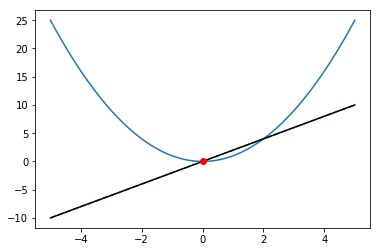

In [129]:
plt.plot(x, f(x))
plt.plot(x, dydx(x), 'g--')
plt.plot(x, numerical_diff(f, x), 'k-')
plt.plot(0, 0, 'ro')

$$ f(x_0, x_1) = x_0^2 + x_1^2 $$

In [130]:
f2 = lambda x: np.sum(x**2, 0)

In [131]:
x0 = np.arange(-5, 5, 0.25)
x1 = np.arange(-5, 5, 0.25)

In [132]:
X0, X1 = np.meshgrid(x0, x1)

In [133]:
from mpl_toolkits.mplot3d import Axes3D

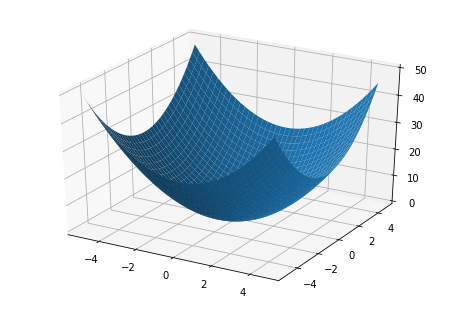

In [134]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X0, X1, f2(np.array([X0, X1])))

In [135]:
def numerical_gradient(f, x):
    h = 1e-4
    기울기 = np.zeros_like(x)
    
    # 편미분: 각 축별로 미분 수행
    for idx in range(len(x)):
        val = x[idx]
        # f(x+h)
        x[idx] = val + h
        fxh1 = f(x) 
        # f(x-h)
        x[idx] = val -h
        fxh2 = f(x)
        # 수치 미분
        기울기[idx] = (fxh1 - fxh2) / (2*h)
        
    return 기울기

In [136]:
numerical_gradient(f2, np.array([3., 4.]))

array([ 6.,  8.])

In [137]:
numerical_gradient(f2, np.array([0., 2.]))

array([ 0.,  4.])

In [138]:
numerical_gradient(f2, np.array([3., .0]))

array([ 6.,  0.])

In [139]:
def 경사하강(f, 시작값, 학습률=0.01, 반복횟수=100):
    x = 시작값    
    x_history = [x.copy()]
    for i in range(반복횟수):
        기울기 = numerical_gradient(f, x)
        # 경사하강법 (G.D.)
        x -= 기울기 * 학습률
        x_history.append(x.copy())
        
    return x_history

In [149]:
시작값 = np.array([-3., 4])

In [150]:
x_history = 경사하강(f2, 시작값, 학습률=0.1)

In [151]:
x_history = np.array(x_history)

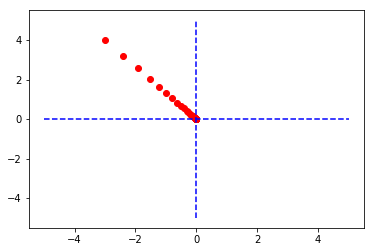

In [152]:
plt.plot(x_history[:, 0], x_history[:, 1], 'ro')
# 보조선
plt.plot([-5, 5], [0, 0], 'b--')
plt.plot([0, 0], [-5, 5], 'b--')

In [153]:
x_history[-1]

array([-0.0005, -0.0005])

In [188]:
# %load neuralnet.py
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def numerical_gradient(f, x):
    h = 1e-4
    기울기 = np.zeros_like(x)
    
    # 편미분: 각 축별로 미분 수행
    for idx in range(len(x)):
        val = x[idx]
        # f(x+h)
        x[idx] = val + h
        fxh1 = f(x) 
        # f(x-h)
        x[idx] = val -h
        fxh2 = f(x)
        # 수치 미분
        기울기[idx] = (fxh1 - fxh2) / (2*h)
        
    return 기울기

def numerical_gradient_batch(f, X):
    if X.ndim == 1:
        return numerical_gradient(f, X)
    
    기울기 = np.zeros_like(X)
    for idx, x in enumerate(X):
        기울기[idx] = numerical_gradient(f, x)
    return 기울기

class Layer:
    def __init__(self, 입력수, 출력수, 활성화):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.random.randn(출력수)
        self.activation = 활성화
        
    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        return self.activation(z)

class FeedForwardNet:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수
        
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, X):
        """신경망 순전파"""
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward(layer_output)            
        y = layer_output
        return y

    def 손실산출(self, X, y):
        y_pred = self.predict(X)
        loss = self.loss_func(y_pred, y)
        return loss
    
    def fit(self, X, y, 학습횟수, 학습률, 배치크기):
        loss_history = []
        for i in range(학습횟수):
            print('훈련', i+1)
            # 1. 미니 배치
            미니배치_색인 = np.random.choice(len(X), 배치크기)
            X_batch = X[미니배치_색인]
            y_batch = y[미니배치_색인]
            # 2. W, b에 대한 기울기 산출
            기울기 = []
            for layer in self.layers:
                f = lambda W: self.손실산출(X_batch, y_batch)
                dW = numerical_gradient_batch(f, layer.W)
                db = numerical_gradient_batch(f, layer.b)
                기울기.append((dW, db))
            # 3. 매개변수 갱신
            for layer, (dW, db) in zip(self.layers, 기울기):
                layer.W -= dW * 학습률
                layer.b -= db * 학습률
            # 4. 손실 수집
            loss = self.손실산출(X_batch, y_batch)
            loss_history.append(loss)
            print('\t손실:', loss)

        return loss_history 

In [189]:
def cross_entropy_error_batch(y_pred, y):
    delta = 1e-7
    batch_size = len(y)
    return -np.sum(y * np.log(y_pred + delta)) / batch_size

In [190]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    y = exp_a / np.sum(exp_a)
    return y

In [191]:
a = np.array([0.3, 2.9, 4.0])
softmax(a)

array([ 0.01821127,  0.24519181,  0.73659691])

In [192]:
A = np.vstack([a, a])
A

array([[ 0.3,  2.9,  4. ],
       [ 0.3,  2.9,  4. ]])

In [193]:
np.apply_along_axis(softmax, 1, A)

array([[ 0.01821127,  0.24519181,  0.73659691],
       [ 0.01821127,  0.24519181,  0.73659691]])

In [194]:
def softmax_batch(A):
    return np.apply_along_axis(softmax, 1, A)

In [195]:
model = FeedForwardNet(손실함수=cross_entropy_error_batch)

In [196]:
model.add(Layer(784, 50, sigmoid))
model.add(Layer(50, 100, sigmoid))
model.add(Layer(100, 10, softmax_batch))

In [197]:
X_train = X_train.reshape(-1, 1*28*28)

In [198]:
X_train = X_train.astype('float32') / 255.

In [199]:
X_train.max(), X_train.min()

(0.0039215689, 0.0)

In [ ]:
Y_train = pd.get_dummies(y_train).values

In [ ]:
loss_history = model.fit(X_train, Y_train, 
                         학습횟수=1000, 학습률=0.01, 배치크기=100)

훈련 1
	손실: 8.53785796675
훈련 2
	손실: 8.47724428478
훈련 3
	손실: 8.35901896245
훈련 4
	손실: 9.0392244414
훈련 5
	손실: 8.11485398632
훈련 6
	손실: 7.84602549627
훈련 7
	손실: 7.5594902721
훈련 8
	손실: 8.39079875111
훈련 9
	손실: 7.28210208558
훈련 10
	손실: 7.35728293194
훈련 11
	손실: 6.89392528196
훈련 12
	손실: 7.463698811
훈련 13
	손실: 6.95149396959
훈련 14
	손실: 6.96372687267
훈련 15
	손실: 6.99769754702
훈련 16
	손실: 6.53482878667
훈련 17
	손실: 6.43691613646
훈련 18
	손실: 7.06960572016
훈련 19
	손실: 6.3912252068
훈련 20
	손실: 6.28606085126
훈련 21
	손실: 5.37075306918
훈련 22
	손실: 6.54090524905
훈련 23
	손실: 5.92245265715
훈련 24
	손실: 5.48778024981
훈련 25
	손실: 6.04768594641
훈련 26
	손실: 6.0751264488
훈련 27
	손실: 5.48244812157
훈련 28
	손실: 5.96350827227
훈련 29
	손실: 5.50175850853
훈련 30
	손실: 5.91341669668
훈련 31
	손실: 4.68613486736
훈련 32
	손실: 5.34433474344
훈련 33
	손실: 5.0105089276
훈련 34
	손실: 5.23600623261
훈련 35
	손실: 5.81914754342
훈련 36
	손실: 4.92392074951
훈련 37
	손실: 5.21994014526
훈련 38
	손실: 4.43166224133
훈련 39
	손실: 5.37423388306
훈련 40
	손실: 3.6887449384
훈련 41
	손실: 5.2678